In [16]:
%matplotlib inline

from IPython.core.pylabtools import figsize
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

In [29]:
# Load the challenger data
data = np.genfromtxt('data/challenger_data.csv', skip_header=1, delimiter=',', usecols=[1, 2])
data

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [80., nan],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.],
       [31., nan]])

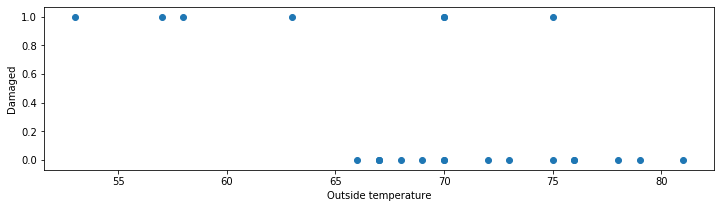

In [30]:
figsize(12, 3)
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('Outside temperature')
plt.ylabel('Damaged')
plt.show()

From the above plot, we can see that as the outside temperature lowers, the likelihood of the O-ring getting damaged increases.

Let's create a bayesian model to determine the probability of the O-ring getting damaged given the outside temperature.

In [32]:
# Remove any missing values
data = data[~np.isnan(data[:, 1])]
data

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.]])

In [33]:
# To model the probability we define a logistic regression model
temperature = data[:, 0]
damaged = data[:, 1]

with pm.Model() as model:
    # Define our priors
    beta = pm.Normal('beta', mu=0, tau=0.001, testval=0)
    alpha = pm.Normal('alpha', mu=0, tau=0.001, testval=0)
    p = pm.Deterministic('p', 1./(1. + tt.exp(beta*temperature + alpha)))
    
    obs = pm.Bernoulli('obs', p, observed=damaged)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, start=start, step=step)
    burned_trace = trace[100000::2]

logp = -19.024, ||grad|| = 9.9071: 100%|██████████| 27/27 [00:00<00:00, 1763.88it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 241000/241000 [00:58<00:00, 4146.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
burned_trace['beta']

array([0.35451003, 0.35451003, 0.35451003, ..., 0.42375907, 0.42375907,
       0.42375907])

In [35]:
burned_trace['alpha']

array([-23.99022086, -23.18305717, -23.18305717, ..., -28.25833652,
       -28.01684618, -27.47184966])

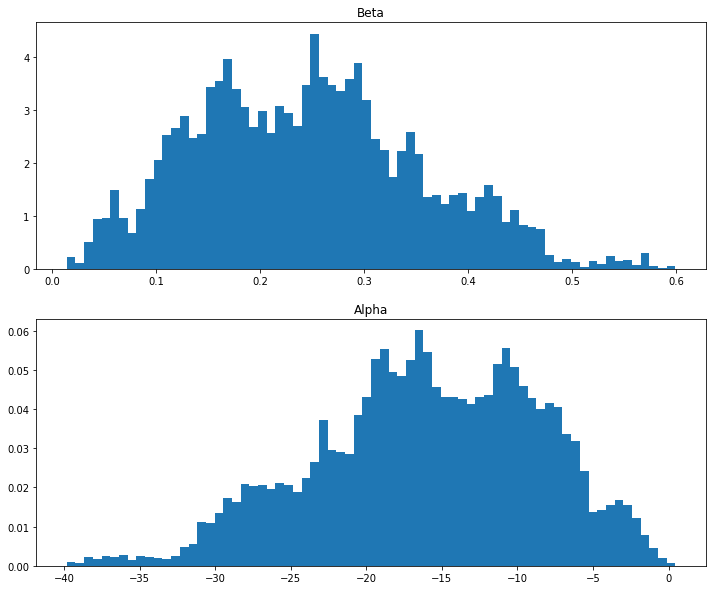

In [39]:
figsize(12, 10)

plt.subplot(211)
plt.hist(burned_trace['beta'], bins=70, density=True)
plt.title("Beta")

plt.subplot(212)
plt.hist(burned_trace['alpha'], bins=70, density=True)
plt.title("Alpha")

plt.show()

Given we have few samples, the posterior distribution has a wide range of values. We are very uncertain about the values of `alpha` and `beta`. Additionally, the values of `alpha` are negative. As the temperature decreases the likelihood of a damage to occur increases. 

Given the temperature, how uncertain are we about our prediction. Let's determine the 95% confidence intervals.

In [51]:
# Generate some temperature values
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)

In [64]:
def logistic(temp, beta, alpha):
    return 1./(1. + np.exp(np.dot(beta, temp) + alpha))

In [97]:
probs = logistic(t[:, None].T, burned_trace['beta'][:, None], burned_trace['alpha'][:, None])
expected_probs = probs.mean(axis=0)

In [100]:
# Determine the 95% CI
qs = stats.mstats.mquantiles(probs, [0.025, 0.975], axis=0)

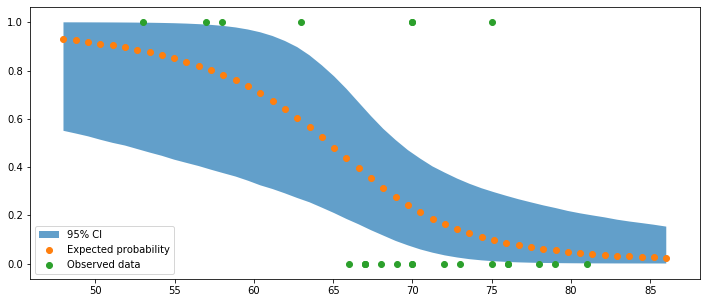

In [107]:
plt.fill_between(t, *qs, alpha=0.7, label="95% CI")
plt.scatter(t, expected_probs, label="Expected probability")
plt.scatter(data[:, 0], data[:, 1], label="Observed data")
plt.legend(loc="lower left")
plt.show()

As the temperature value increases, we are more confident our results relative to when the temperature value is between 55-60.

## What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring, given this temperature?

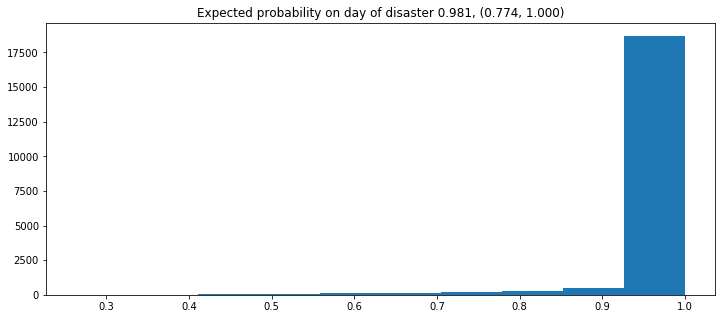

In [113]:
prob_31 = logistic(31, burned_trace['beta'], burned_trace['alpha'])
ci_prob_31 = stats.mstats.mquantiles(prob_31, [0.025, 0.975])

plt.hist(prob_31)
plt.title("Expected probability on day of disaster {:.3f}, ({:.3f}, {:.3f})".format(
    prob_31.mean(), ci_prob_31[0], ci_prob_31[1]))
plt.show()